In [15]:
"""
    author: Suhas Vittal
    date:   7 March 2024
"""

# Color palette:
c1 = '#7D0A0A'
c2 = '#BF3131'
c3 = '#EAD196'
c4 = '#F3EDC8'
c5 = '#004225'
c6 = '#F5F5DC'
c7 = '#FFB000'
c8 = '#FFCF9D'

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from collections import defaultdict

import os

plt.rcParams['pdf.fonttype'] = 42

In [17]:
def split_csv_line(line: str, delim=',') -> list[str]:
    dat = []
    in_quote = False
    curr = []
    for c in line:
        if c == '\"':
            in_quote = not in_quote
        elif c == ',':
            if in_quote:
                curr.append(c)
            else:
                dat.append(''.join(curr))
                curr = []
        else:
            curr.append(c)
    dat.append(''.join(curr))
    return dat

def get_arch_stats(benchmark, version):
    fname = f'../../data/protean/{benchmark}/v{version}/stats.txt'
    with open(fname, 'r') as reader:
        lines = reader.readlines()[1:] # Ignore the first line -- just a header.
    stats = {}
    for line in lines:
        d = line.split(',')
        stats[d[0]] = float(d[1])
    return stats

def code_name(benchmark):
    return benchmark.split('/')[2]

def get_stats_from_code_name(name):
    # Format is n_k_dz_dx
    d = name.split('_')
    return { 'n': int(d[0]), 'k': int(d[1]), 'dz': int(d[2]), 'dx': int(d[3]) }

def format_code_name(name):
    stats = get_stats_from_code_name(name)
    n, k, dz, dx = stats['n'], stats['k'], stats['dz'], stats['dx']
    return '[[%d, %d, %d, %d]]' % (n, k, dz, dx) 

def get_error_rates_from_file(f, ler_key=-1):
    with open(f, 'r') as reader:
        lines = reader.readlines()[1:]
    X, Y = [], []
    for line in lines:
        d = line.split(',')
        if float(d[-1]) > 0:
            X.append(float(d[0]))
            Y.append(float(d[ler_key]))
    X, Y = zip(*sorted(zip(X, Y)))
    return X, Y

def get_rsc_error_rates(d, mem):
    f = f'../../data/protean/rsc/output/{mem}_d{d}.csv'
    return get_error_rates_from_file(f)

def get_hexcc_error_rates(d, mem):
    f = f'../../data/protean/hexcc/output/{mem}_d{d}.csv'
    return get_error_rates_from_file(f)

def get_code_error_rates(code, version, ler_key=-1):
    f = f'../../data/protean/{code}/v{version}/output/basic_memory_z.csv'
    return get_error_rates_from_file(f, ler_key=ler_key)


Mean flag overheads for v=3.4: 0.4939694859493792
Mean flag overheads for v=3.4: 0.49231705514776775


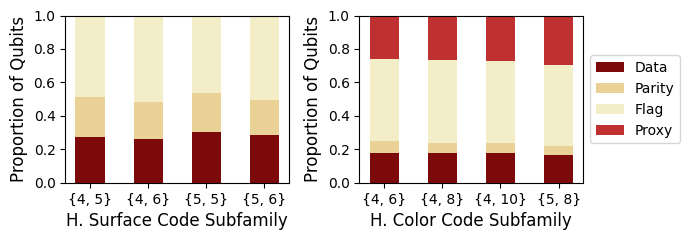

In [18]:
#
# FIGURE 10(A)
#
def get_overheads_by_qubit(code, version):
    f = f'../../data/protean/{code}/v{version}/roles.txt'
    with open(f, 'r') as reader:
        lines = reader.readlines()[1:] # First line is header.
    n_data, n_parity, n_flag, n_proxy = 0, 0, 0, 0
    for line in lines:
        dat = split_csv_line(line)
        q, roles = int(dat[0]), dat[2]
        if 'd' in roles:
            n_data += 1
        elif 'x' in roles or 'z' in roles:
            n_parity += 1
        elif 'f' in roles:
            n_flag += 1
        else:
            n_proxy += 1
    tot = n_data + n_parity + n_flag + n_proxy
    n_data /= tot
    n_parity /= tot
    n_flag /= tot
    n_proxy /= tot
    return n_data, n_parity, n_flag, n_proxy

def get_mean_overheads_for_subfamily(family, subfamily, version):
    base_folder = f'../../data/protean/{family}/{subfamily}'
    codes = [f for f in os.listdir(base_folder) if os.path.exists(f'{base_folder}/{f}/v{version}/roles.txt')]
    if len(codes) == 0:
        print(f'No codes for {family}/{subfamily}')
        return 0, 0, 0, 0
    md, mp, mf, mr = 0, 0, 0, 0
    for f in codes:
        nd, np, nf, nr = get_overheads_by_qubit(f'{family}/{subfamily}/{f}', version)
        md += nd
        mp += np
        mf += nf
        mr += nr
    md /= len(codes)
    mp /= len(codes)
    mf /= len(codes)
    mr /= len(codes)
    return md, mp, mf, mr

## Flag Overhead Plot -- no sharing
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(7, 2.5)

subf = {'hysc': ['4_5', '4_6', '5_5', '5_6'], 'hycc': ['4_6', '4_8', '4_10', '5_8']}

version = '3.4'
def add_data_to_ax(ax, family, xlabel):
    data = {'Data': [], 'Parity': [], 'Flag': [], 'Proxy': []}
    for sf in subf[family]:
        md, mp, mf, mr = get_mean_overheads_for_subfamily(family, sf, version)
        data['Data'].append(md)
        data['Parity'].append(mp)
        data['Flag'].append(mf)
        data['Proxy'].append(mr)
    base = np.zeros(len(subf[family]))
    for k in data:
        data[k] = np.array(data[k])
    color_dict = {'Data': c1, 'Parity': c3, 'Flag': c4, 'Proxy': c2}
    code_names = []
    for sf in subf[family]:
        r, s = [int(x) for x in sf.split('_')]
        code_names.append('{%d, %d}' % (r, s))
    for (k, v) in data.items():
        ax.bar(code_names, v, 0.5, label=k, bottom=base, color=color_dict[k])
        base += v
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Proportion of Qubits', fontsize=12)
    ax.set_ylim([0.0, 1.0])
    
    print(f'Mean flag overheads for v={version}:', data['Flag'].mean())
add_data_to_ax(ax1, 'hysc', 'H. Surface Code Subfamily')
add_data_to_ax(ax2, 'hycc', 'H. Color Code Subfamily')

#ax1.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax2.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.tight_layout()
plt.savefig('plots/figure_10a.pdf')

In [19]:
#
# TABLE-I DATA
#

def get_mean_connectivity_for_subfamily(family, subfamily):
    base_folder = f'../../data/protean/{family}/{subfamily}'
    codes = [f for f in os.listdir(base_folder) if os.path.exists(f'{base_folder}/{f}/v4.4/roles.txt')]
    mc = 0
    for c in codes:
        dat = get_arch_stats(f'{family}/{subfamily}/{c}', '4.4')
        mc += dat['Mean Degree']
    mc /= len(codes)
    return mc

subf = {'hysc': ['4_5', '4_6', '5_5', '5_6'], 'hycc': ['4_6', '4_8', '4_10', '5_8']}
for fam in ['hysc', 'hycc']:
    for sf in subf[fam]:
        mc = get_mean_connectivity_for_subfamily(fam, sf)
        print(f'Mean conn for {fam}/{sf} = {mc}')
# Mean sc conn:
def print_mean_sc_conn(d):
    mscc = ( ( 4*(d-2)*(d-2) + 3*4*(d-2) + 2*4 ) + ( 4*(d-1)*(d-1) + 2*2*(d-1) ) ) / (2*d*d-1)
    print(f'Mean conn for d={d} SC = {mscc}')
print_mean_sc_conn(3)
print_mean_sc_conn(5)
print_mean_sc_conn(7)

Mean conn for hysc/4_5 = 2.971043333333333
Mean conn for hysc/4_6 = 2.9308785714285714
Mean conn for hysc/5_5 = 3.0746200000000004
Mean conn for hysc/5_6 = 3.0988049999999996
Mean conn for hycc/4_6 = 2.836196
Mean conn for hycc/4_8 = 2.87166
Mean conn for hycc/4_10 = 2.82877
Mean conn for hycc/5_8 = 2.9150033333333334
Mean conn for d=3 SC = 2.823529411764706
Mean conn for d=5 SC = 3.2653061224489797
Mean conn for d=7 SC = 3.463917525773196


[1.6164686  2.62850023 3.86435331 4.57106839 2.94335374]
2.94335373748922 4.571068389536715
[3.4765471  5.25568797 6.2074426  6.91535282 5.29207739]
5.29207739071238 6.91535282412368


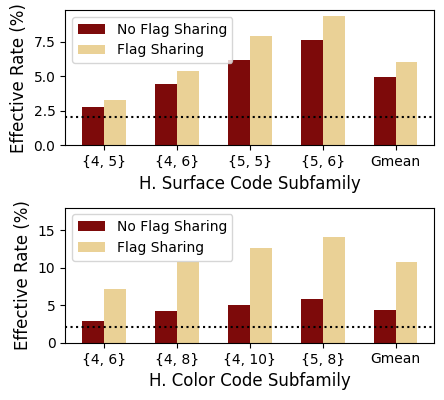

In [20]:
#
# FIGURE 12
#

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(4.5, 4.1)
subf = {'hysc': ['4_5', '4_6', '5_5', '5_6'], 'hycc': ['4_6', '4_8', '4_10', '5_8']}
def get_effective_rate(family, subfamily, v):
    base_folder = f'../../data/protean/{family}/{subfamily}'
    codes = [f for f in os.listdir(base_folder) if os.path.exists(f'{base_folder}/{f}/v4.4/roles.txt')]
    tot_k, tot_N = 0, 0
    for f in codes:
        stats = get_arch_stats(f'{family}/{subfamily}/{f}', v)
        tot_k += get_stats_from_code_name(f)['k']
        tot_N += stats['Qubits']
    return tot_k / tot_N

scr = 1/49 * 100

def add_data_to_ax(ax, family, xlabel):
    ax.axhline(y=scr, linestyle=':', color='k')
    
    code_names = []
    y1, y2 = [], []
    for sf in subf[family]:
        r, s = [int(x) for x in sf.split('_')]
        code_names.append('{%d, %d}' % (r, s))
        y1.append(get_effective_rate(family, sf, '3.4')*100)
        y2.append(get_effective_rate(family, sf, '4.4')*100)
    code_names.append('Gmean')
    y1.append(sp.stats.gmean(y1))
    y2.append(sp.stats.gmean(y2))
    x = np.arange(0, len(code_names))
    ax.bar(x, y1, width=0.3, label='No Flag Sharing', color=c1)
    ax.bar(x+0.3, y2, width=0.3, label='Flag Sharing', color=c3)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Effective Rate (%)', fontsize=12)
    ax.set_xticks(x+0.15, code_names)
#    ax.grid(visible=True, axis='y')
    ax.legend(fontsize=10)

    y2 = np.array(y2)
    print(y2/scr)
    print(sp.stats.gmean(y2/scr), y2.max()/scr)
ax2.set_ylim([0, 18])
add_data_to_ax(ax1, 'hysc', 'H. Surface Code Subfamily')
add_data_to_ax(ax2, 'hycc', 'H. Color Code Subfamily')
plt.tight_layout()
plt.savefig('plots/figure_12.pdf', bbox_inches='tight')

1.0179661963527087 0.8759928445031812
1.0991406904895815 0.8754887643536826


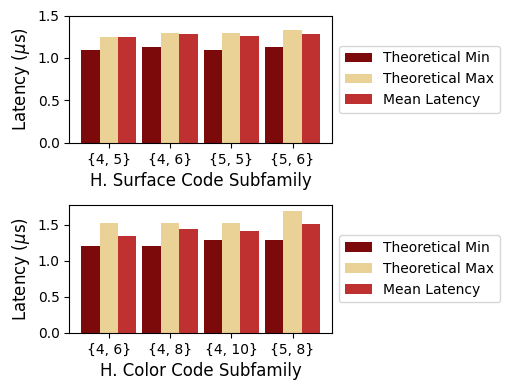

In [27]:
#
# FIGURE 14
#
def get_mean_latency(fam, sfam, v):
    base_folder = f'../../data/protean/{fam}/{sfam}'
    codes = [f for f in os.listdir(base_folder) if os.path.exists(f'{base_folder}/{f}/v{v}/stats.txt')]
    mlat = 0.0
    for c in codes:
        stats = get_arch_stats(f'{fam}/{sfam}/{c}', v)
        mlat += stats['Round Latency']
    mlat /= len(codes)
    return mlat
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(5.2, 4)
subf = {'hysc': ['4_5', '4_6', '5_5', '5_6'], 'hycc': ['4_6', '4_8', '4_10', '5_8']}

def add_data_to_ax(ax, family, xlabel):
    code_names = []
    y1, y2, y3 = [], [], []
    for sf in subf[family]:
        r, s = [int(x) for x in sf.split('_')]
        code_names.append('{%d, %d}' % (r, s))
        if family == 'hysc':
            y1.append( (890 + 40*max(r,s))/1000 )
            y2.append( (890 + 40*(r+s))/1000 )
        else:
            y1.append( (890 + 40*max(2*r,s))/1000 )
            y2.append( (890 + 40*(4*r))/1000 )
        y3.append(get_mean_latency(family, sf, '1')/1000)
    x = np.arange(0, len(code_names))
    y1,y2,y3 = np.array(y1), np.array(y2), np.array(y3)
    print(sp.stats.gmean(y2/y3), sp.stats.gmean(y1/y3))
    ax.bar(x, y1, width=0.3, label='Theoretical Min', color=c1)
    ax.bar(x+0.3, y2, width=0.3, label='Theoretical Max', color=c3)
    ax.bar(x+0.6, y3, width=0.3, label='Mean Latency', color=c2)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Latency ($\mu$s)', fontsize=12)
    ax.set_xticks(x+0.3, code_names)
#    ax.grid(visible=True, axis='y')
    ax.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
    ax.set_yticks([0,0.5,1.0,1.5])

add_data_to_ax(ax1, 'hysc', 'H. Surface Code Subfamily')
add_data_to_ax(ax2, 'hycc', 'H. Color Code Subfamily')
plt.tight_layout()
plt.savefig('plots/figure_14.pdf', bbox_inches='tight')

160_18_8_6 (4.91287e-07, 7.06425e-07, 1.32455e-06, 1.80138e-06, 2.16166e-06, 2.96699e-06)
160_18_8_6 (2.75506e-06, 5.08626e-06, 1.13381e-05, 1.41992e-05, 2.0557e-05, 3.43323e-05)
150_32_6_6 (3.75509e-06, 5.78165e-06, 8.46386e-06, 1.45435e-05, 2.01464e-05, 3.09944e-05)
150_32_6_6 (4.41074e-06, 6.91414e-06, 1.09673e-05, 1.70469e-05, 2.72989e-05, 3.75509e-05)


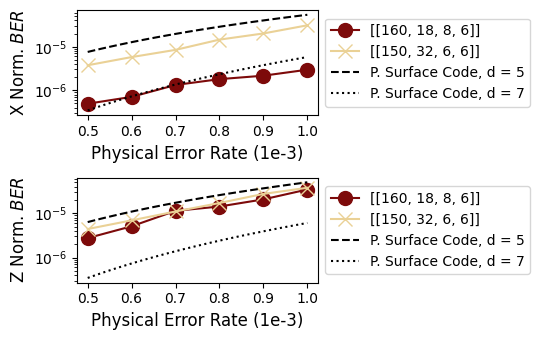

In [13]:
#
# FIGURE 17
#
def plot_error_rate_curve(ax, x, y, marker, color, ms, label):
    x = np.array(x)
    y = np.array(y)
    lgx, lgy = np.log(x), np.log(y)
    res = sp.stats.linregress(lgx, lgy)
    a, b = res.slope, res.intercept
    b = np.e**b
    curve = lambda p: b*(p**a)

    x = np.arange(0.5, 1.01, 0.01)
    y = np.array([curve(_x) for _x in x])
    ax.plot(x, y, marker, color=color, ms=ms, label=label)

def add_sc_data_to_ax(ax, mem):
    colors = [c5, c7, c8]
    markers = ['--', ':', '-.']
    for (i,d) in enumerate([5, 7]):
        x, y = get_rsc_error_rates(d, mem)
        x = [1000*_x for _x in x]
        plot_error_rate_curve(ax, x, y, markers[i], 'k', 5, f'P. Surface Code, d = {d}')
#        ax.plot(x, y, markers[i], color='k', ms=5, label=f'SC, d = {d}')

def add_cc_data_to_ax(ax, mem):
    colors = [c5, c7, c8]
    markers = ['--', ':', '-.']
    for (i,d) in enumerate([5, 7]):
        x, y = get_hexcc_error_rates(d, mem)
        x = [1000*_x for _x in x]
        plot_error_rate_curve(ax, x, y, markers[i], 'k', 5, f'P. Color Code, d = {d}')
#        ax.plot(x, y, markers[i], color='k', ms=5, label=f'CC, d = {d}')
    

def add_code_data_to_ax(ax, family, subfamily, code, marker, color, mx=False):
    data_file = 'basic_memory_x.csv' if mx else 'basic_memory_z.csv'
    x, y = get_error_rates_from_file(f'../../data/protean/{family}/{subfamily}/{code}/v4.4/output/{data_file}')
    x = [1000*_x for _x in x]
    print(code, y)
#    plot_error_rate_curve(ax, x, y, marker, color, 10, format_code_name(code))
    ax.plot(x, y, marker, color=color, ms=10, label=format_code_name(code))
    
## Surface Code Error Rate Plot
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(5.5, 3.5)

#codes = [('4_5', '160_18_8_6'), ('4_6', '96_18_6_4'), ('5_5', '150_32_6_6'), ('5_6', '120_34_6_5')]
codes = [('4_5', '160_18_8_6'), ('5_5', '150_32_6_6')]
markers = ['o-', 'x-', '^-', '^-']
#markers = ['-', '-.']
colors = [c1, c3, c2]
for (i, (sf, c)) in enumerate(codes):
    add_code_data_to_ax(ax1, 'hysc', sf, c, markers[i], colors[i])
    add_code_data_to_ax(ax2, 'hysc', sf, c, markers[i], colors[i], True)
    
add_sc_data_to_ax(ax1, 'z')
add_sc_data_to_ax(ax2, 'x')
for ax in (ax1, ax2):
    ax.set_xlabel('Physical Error Rate (1e-3)', fontsize=12)
    ax.set_yscale('log')
    ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax1.set_ylabel('X Norm. $BER$', fontsize=12)
ax2.set_ylabel('Z Norm. $BER$', fontsize=12)
plt.tight_layout()
plt.savefig('plots/figure_17.pdf', bbox_inches='tight')

216_40_8_8 (3.05176e-06, 6.69691e-06, 1.33938e-05, 2.72963e-05, 4.0351e-05, 7.18859e-05)
216_40_8_8 (4.40809e-06, 6.52737e-06, 1.57674e-05, 2.89917e-05, 5.08626e-05, 8.00239e-05)
360_130_6_6 (0.000173055, 0.000290563, 0.000469076, 0.000705279, 0.00101792, 0.00141357)
360_130_6_6 (0.000166805, 0.000291135, 0.00047446, 0.000724792, 0.00104502, 0.00146273)


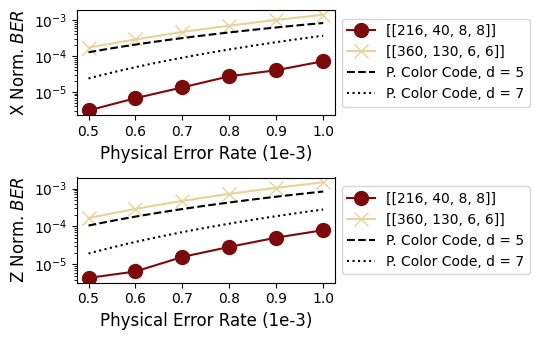

In [14]:
#
# FIGURE 18
#
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(5.5, 3.5)

codes = [('4_6', '216_40_8_8'), ('5_8', '360_130_6_6')]
markers = ['o-', 'x-', '^-', '^-']
#markers = ['-', '-.']
colors = [c1, c3, c2]
for (i, (sf, c)) in enumerate(codes):
    add_code_data_to_ax(ax1, 'hycc', sf, c, markers[i], colors[i])
    add_code_data_to_ax(ax2, 'hycc', sf, c, markers[i], colors[i], True)

add_cc_data_to_ax(ax1, 'z')
add_cc_data_to_ax(ax2, 'x')
for ax in (ax1, ax2):
    ax.set_xlabel('Physical Error Rate (1e-3)', fontsize=12)
    ax.set_yscale('log')
    ax.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax1.set_ylabel('X Norm. $BER$', fontsize=12)
ax2.set_ylabel('Z Norm. $BER$', fontsize=12)
plt.tight_layout()
plt.savefig('plots/figure_18.pdf', bbox_inches='tight')

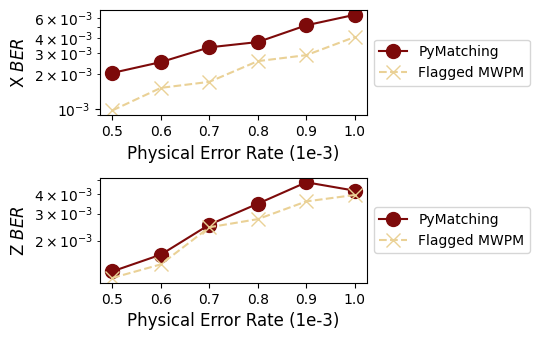

In [11]:
#
# FIGURE 19
#
f = '../../data/protean/hysc/5_5/30_8_3_3'
f1 = f'{f}/v1'
f2 = f'{f}/v4.4'

fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(5.5,3.5)

def plot_folder(folder, marker, color, label):
    x1,y1,x2,y2 = [],[],[],[]
    with open(f'{folder}/output/basic_memory_z.csv', 'r') as reader:
        lines = reader.readlines()[1:]
        for line in lines:
            ld = line.split(',')
            x1.append(float(ld[0]) *1000)
            y1.append(float(ld[1]))
    with open(f'{folder}/output/basic_memory_x.csv', 'r') as reader:
        lines = reader.readlines()[1:]
        for line in lines:
            ld = line.split(',')
            x2.append(float(ld[0]) *1000)
            y2.append(float(ld[1]))
    ax1.plot(x1,y1, marker, color=color, ms=10, label=label)
    ax2.plot(x2,y2, marker, color=color, ms=10, label=label)
plot_folder(f1,'o-',c1,'PyMatching')
plot_folder(f2,'x--',c3,'Flagged MWPM')

for ax in [ax1,ax2]:
    ax.set_xlabel('Physical Error Rate (1e-3)',fontsize=12)
    ax.set_yscale('log')
    ax.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax1.set_ylabel('X $BER$', fontsize=12)
ax2.set_ylabel('Z $BER$', fontsize=12)
plt.tight_layout()
plt.savefig('plots/mwpm_decoder_cmp.pdf', bbox_inches='tight')

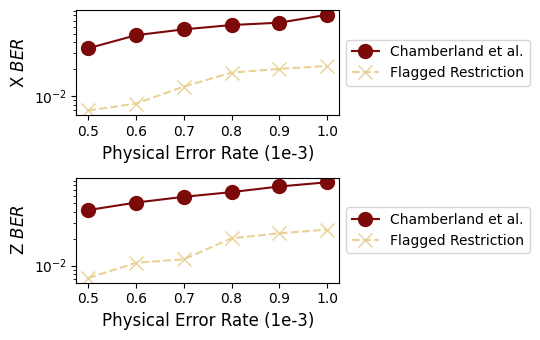

In [12]:
#
# FIGURE 20
#
f = '../../data/protean/hycc/4_6/24_8_4_4/v4.4'

fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(5.5,3.5)

with open(f'{f}/output/basic_memory_z.csv', 'r') as reader:
    lines = reader.readlines()[1:]
    x,y=[],[]
    for line in lines:
        ld = line.split(',')
        x.append(float(ld[0])*1000)
        y.append(float(ld[1]))
    x1,x2,y1,y2 = x[:6],x[6:],y[:6],y[6:]
    ax1.plot(x1,y1, 'o-', color=c1, ms=10, label='Chamberland et al.')
    ax1.plot(x2,y2, 'x--', color=c3, ms=10, label='Flagged Restriction')
with open(f'{f}/output/basic_memory_x.csv', 'r') as reader:
    lines = reader.readlines()[1:]
    x,y=[],[]
    for line in lines:
        ld = line.split(',')
        x.append(float(ld[0])*1000)
        y.append(float(ld[1]))
    x1,x2,y1,y2 = x[:6],x[6:],y[:6],y[6:]
    ax2.plot(x1,y1, 'o-', color=c1, ms=10, label='Chamberland et al.')
    ax2.plot(x2,y2, 'x--', color=c3, ms=10, label='Flagged Restriction')

for ax in [ax1,ax2]:
    ax.set_xlabel('Physical Error Rate (1e-3)',fontsize=12)
    ax.set_yscale('log')
    ax.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax1.set_ylabel('X $BER$', fontsize=12)
ax2.set_ylabel('Z $BER$', fontsize=12)
plt.tight_layout()
plt.savefig('plots/cc_decoder_cmp.pdf', bbox_inches='tight')